In [1]:
#import packages for data viz

import numpy as np
import pandas as pd
import matplotlib as plt
import math as math
import geopandas as gpd
import matplotlib.pyplot as plt



   Load the Data


In [2]:
#import data from csv
store_data = pd.read_csv("/Users/zach/Downloads/Sample-Superstore.csv", encoding = 'latin1')

Display the first 5 rows of data with all columns visible

In [3]:
pd.set_option('display.max_columns', None)
store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Data Cleaning

Check for nans

In [4]:
nan_check = store_data.isnull().values.any()
print(nan_check)

False


No nan values are inside the dataframe. For the purposes of data viz, the data appears ready.


# Visualization 1: Customer Density

This visualization will show customer density on a geographic map at the national and state level.

Load geoencoder and test if it is imported correctly

In [5]:
from geopy.geocoders import Nominatim #import the Nomination geoencoder


geolocator = Nominatim(user_agent="Data_Challenge") #create a geolocator object


location = geolocator.geocode("Henderson") #set location to the geographic coorindates of the city Henderson
print(location.latitude) #test if the geolocator is working correctly

32.182598


Cycle through all postal codes in the dataset and attempt to find the geographic coordinates for each postal code. If coordinates are not found, append the postal code to miss_list. Misses totals the number of misses addresses

In [6]:
latitude_list = [] #lists for the coordinates, as well as a list for all the location the geolocator was unable to find
longitude_list = []
miss_list = []
misses = 0
for postal_code in store_data.loc[:,"Postal Code"]: #loop through all postal codes in the dataframe
    try:
        print(postal_code) #print the postal code being geolocated
        
        #set the location equal to the postal code being geolocated
        location = geolocator.geocode(query={'postalcode':str(postal_code)}, timeout = 10, country_codes = "us")
        print(location) #print the location
        #append the geographic coordinates to their respective lists
        latitude_list.append(location.latitude)
        longitude_list.append(location.longitude)
        
    except: 
        misses+=1 #if a postal code is unable to be geolocated, append the postal code to miss_list
        miss_list.append(postal_code)
        continue

    

42420
Henderson County, Kentucky, 42420, United States
42420
Henderson County, Kentucky, 42420, United States
90036
90036
33311
Fort Lauderdale, Broward County, Florida, 33311, United States
33311
Fort Lauderdale, Broward County, Florida, 33311, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
90032
Los Angeles, Los Angeles County, CAL Fire Southern Region, California, 90032, United States
28027
Concord, Cabarrus County, North Carolina, 28027,

In [7]:
print(len(longitude_list)) #print the len of lists to ensure it cycled through all examples
print(len(latitude_list))

9545
9545


compile the latitude and longitude coordinate lists into a dataframe

In [8]:
coords = pd.DataFrame(list(zip(latitude_list,longitude_list)), columns = ['Latitude', 'Longitude'])

In [9]:
coords.head()

,Latitude,Longitude
0,37.829548,-87.558589
1,37.829548,-87.558589
2,34.067386,-118.353265
3,26.144089,-80.171380
4,26.144089,-80.171380


In [10]:
print(misses)
print("miss pecercentage = " + str(misses/len(latitude_list)*100) + "%")

449
miss pecercentage = 4.704033525405972%


Approximately 5% of the postal codes did not yield coordinates. In the majority of cases, preserving 95% of the data is likely enough, particularly since the missing postal codes are from low population density areas. If one wishes to find the remaining 5%, they could find the number of unique postal codes in the miss list, find them by hand, then find the number of duplicates for each postal code on miss list, and finally append the searched coords to the coords dataframe.

# Plot 1: Population density with no background

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

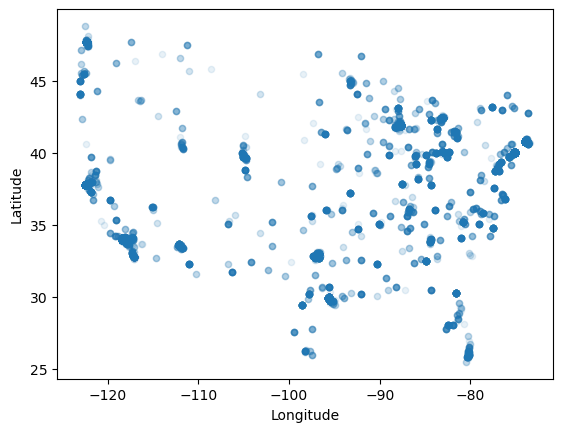

In [11]:
coords.plot(x = "Longitude", y = "Latitude", kind = "scatter", alpha = 0.1) #plot the density of customers 

The plot above appears to resemble an outline of the US. This is unsuprising considering all the datapoints' country component = "United States." 

Since we know all datapoints reside in mainland US, projecting the borders of the US states onto the density plot will make it easier to identify density by state

In [12]:
states = gpd.read_file('/Users/zach/Downloads/usa-states-census-2014.shp') #load state geographic data from 2014 census

# Plot 2: Population density with US state borders

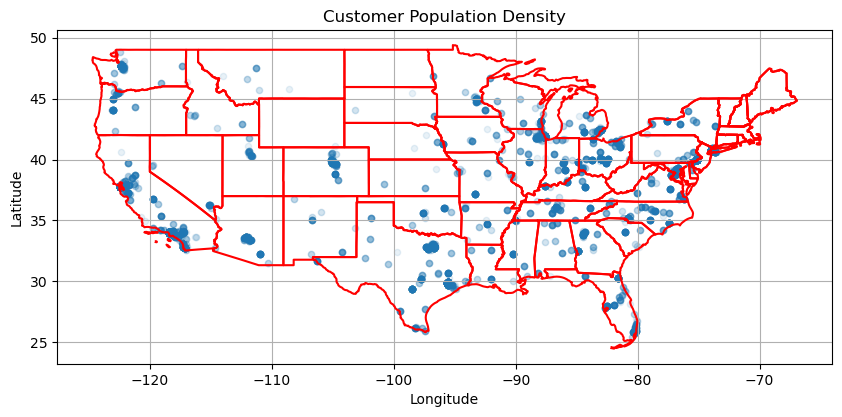

In [13]:
fig, ax = plt.subplots(figsize =(10,10)) #create fig


states.boundary.plot(color ="red",  ax=ax) #plot the state boundaries

#plot the customer density 
coords.plot(x = "Longitude", y = "Latitude", kind = "scatter", alpha = 0.1, \
           title = "Customer Population Density", ax=ax)
ax.grid(visible=True, alpha = 1)


With the boundaries shown, it is apparent that certain states have a much higher density than other states. California and Flordia, fior examples, have several high-desnity pockets.

The two plots above demonstrate a problem: while the plots are useful for regional inference, it is difficult to tell where the most dense locations are in individual states. 

The function below gets all coordinates for all customers in the specified state and returns two lists with the coordinates.

In [14]:
def get_points_in_state(state):
    count = 0 #var to loop through rows
    state_longitude = [] #lists for geographic coordinates
    state_latitude = []
    for state1 in store_data.loc[:,"State"]: #loop through states column and all features
        if(str(state1) == str(state)): #true if the parameter is equal to the value in the state column

            try:
              
                postal_code = store_data.iat[count,11] #get postal code
               
                
                print(postal_code)
                
                #get location and append it to the respective lists
                location = geolocator.geocode(query={'postalcode':str(postal_code)}, timeout = 10, country_codes = "us")
                state_longitude.append(location.latitude)
                state_latitude.append(location.longitude)
            except: #if a location is unable to be obtained, pass ot the next location
                pass
            
        count+=1
    return state_longitude, state_latitude #return geographic coordinate lists
    

In [15]:
tex_lat, tex_long = get_points_in_state("Texas") #get geographic coordinates for Texas customers

76106
76106
77095
75080
75080
77041
77041
77041
77041
77041
77041
77041
77070
77095
77041
78207
78207
78207
78207
78207
78207
78207
77036
75051
75051
75220
75220
77506
77036
77036
77070
77070
78745
78550
78550
77095
77095
77095
77036
77036
77036
77036
78207
77070
79109
77340
77340
77340
77041
77041
77041
76106
76106
76106
77070
78041
78041
75217
75217
76017
76017
76017
76017
75081
75081
75081
75701
75701
75701
75701
78745
78745
75220
75220
75220
75220
75701
76106
77095
75043
75043
78207
78207
78207
75220
75220
78664
78664
77506
77506
77506
77041
77095
78521
77041
77041
77041
77041
77041
77041
77041
77041
77041
77041
77070
77041
77041
77041
76106
76106
76106
76106
77070
78745
77036
75220
75220
77036
77036
76106
75051
77041
77041
77041
79109
79109
75061
77506
77506
77036
75019
75019
75019
78745
78745
78745
75220
75220
75220
78207
78207
78207
77095
75002
75002
79907
79907
76051
76051
75007
75007
75007
75007
75217
75217
75217
75217
75217
75217
77095
75023
77041
77041
75023
77070
75081
7508

Compile the coordinates for Texas into a dataframe

In [16]:
texas_coords = pd.DataFrame(list(zip(tex_lat,tex_long)), columns = ['Latitude', 'Longitude'])

# Plot 3: Texas customer density

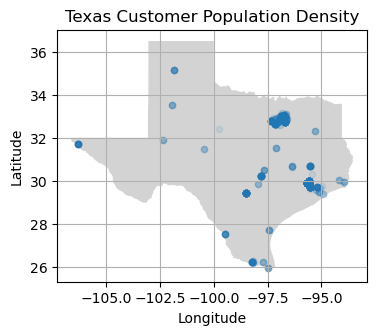

In [17]:
fig, ax = plt.subplots(figsize =(4,5)) #create fig


states[states['NAME'] == 'Texas'].plot(ax=ax, color = "lightgrey") #set parameters for texas state projection
 
#plot texas customer density
texas_coords.plot(x = "Longitude", y = "Latitude", kind = "scatter", alpha = 0.1, \
           title = "Texas Customer Population Density", ax=ax)
ax.grid(visible=True, alpha = 1)

# Visualization 2: Comparing Regional Profit and Customer Proportions

This visualization compares the regional profit to the proportion of customer base.

In [18]:
def get_profit(region): 
    count = 0
    sum_profit = 0
    customer_count = 0
    for profit in store_data.loc[:,"Profit"]: #loop through profit column and all features
        
        if(str(store_data.iat[count,12]) == region): #if the region is equal to the parameter sum the profit
               
                
            sum_profit+= profit
            customer_count+=1
        count+=1
 
    return sum_profit, customer_count #return the customer count and profit for the region


In [19]:
south_profit, south_cus = get_profit("South") #get south region profit and customer base

In [20]:
print(south_profit)

46749.430300000065


In [21]:
east_profit, east_cus = get_profit("East")  #get east region profit and customer base
print(east_profit)

91522.78000000026


In [22]:
west_profit, west_cus = get_profit("West") #get west region profit and customer base
print(west_profit)

108418.44890000018


In [23]:
central_profit, central_cus = get_profit("Central") #get central region profit and customer base

In [24]:
print(central_profit)

39706.36249999998


# Plot 1: Profit per region vs customer population proportions

Text(0.5, 1.0, 'Customer Population Proportions')

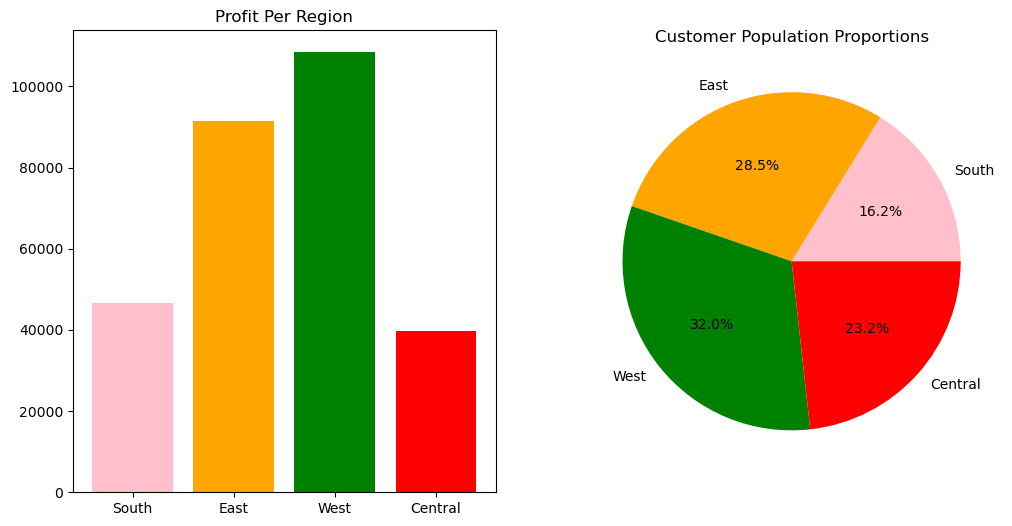

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) #initialize fig
labels = ["South", "East", "West", "Central"] #set labels for sub plots
bar_vals = [south_profit, east_profit, west_profit, central_profit] #create list for bar chart values
axs[0].bar(labels,bar_vals, color = ["pink", "orange", "green", "red"]) #set chart colors to respective regions
axs[0].set_title('Profit Per Region') #set chart title
# ...
pie_vals = [south_cus, east_cus, west_cus, central_cus] #set pie chart values

#set the labels, colors, and percent pointer precision
axs[1].pie(pie_vals,labels = labels, colors = ["pink", "orange", "green", "red"], autopct = '%1.1f%%') 
axs[1].set_title('Customer Population Proportions') #set title of pie chart

In this visualization, we see that the central region is underpreforming compared to the other 3 regions. Further investigation into the cause of this could yield insight into why central region does not generate as much profit.

# Visualization 3: Agregate Profit Over Time

The final visualization will show total profit over time. The time series can then be used to identitfy how profit responds to business cycles

In [44]:
df = store_data[['Order Date','Profit']].copy() #create a new dataframe with the order date and profit columns

In [45]:
df['datetime'] = pd.to_datetime(df['Order Date']) #convert the order date into a datetime object column


df.head()

,Order Date,Profit,datetime
0,11/8/2016,41.9136,2016-11-08
1,11/8/2016,219.5820,2016-11-08
2,6/12/2016,6.8714,2016-06-12
3,10/11/2015,-383.0310,2015-10-11
4,10/11/2015,2.5164,2015-10-11


In [47]:
df.sort_values(by='datetime', inplace = True) #look at distribution of profit values 
df.describe()

,Profit
count,9994.000000
mean,28.656896
std,234.260108
min,-6599.978000
25%,1.728750
50%,8.666500
75%,29.364000
max,8399.976000


In [48]:
df #check that index is pointing to row ID

,Order Date,Profit,datetime
7980,1/3/2014,5.5512,2014-01-03
739,1/4/2014,4.2717,2014-01-04
740,1/4/2014,-64.7748,2014-01-04
741,1/4/2014,-5.4870,2014-01-04
1759,1/5/2014,4.8840,2014-01-05
...,...,...,...
5091,12/30/2017,-0.6048,2017-12-30
908,12/30/2017,19.7910,2017-12-30
907,12/30/2017,2.7279,2017-12-30
1296,12/30/2017,4.5188,2017-12-30


In [49]:
profit = 0 
i = 0
for column in df["Profit"]: #loop over all columns
    profit += column #sum profit
    df.iat[i,1] = profit
    i+=1
    
    

<AxesSubplot:xlabel='datetime'>

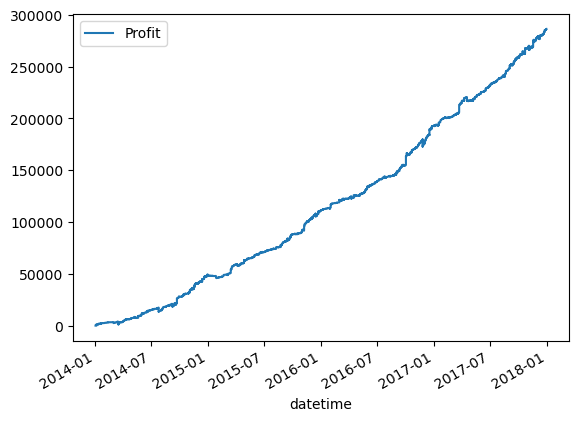

In [50]:
df.plot( x = 'datetime', y = "Profit") #plot profit vs time

Profit appears relatively linear over time. There is a noticable drop in profit and subsequent growth 
between 2015-01 and 2016-07, but there is a surge soon after, which suggests this may be due to a dip in the business cycle.

# Prediction: Customer Segement

The purpose of predicting the customer segement is to see if certain segements are more prone to particular types of purchases. If they are, this data could be used for advertising targeting and discount offers.

In [51]:
pd.set_option('display.max_columns', None)
store_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Data Cleaning

While there are no nans in the dataset, some of the columns will need to be dropped since they are not relevant to predicting custoemr segement

In [52]:
#create a new dataframe that contains only the relevant columns
prediction_df = store_data[['Sales', 'Region', 'Ship Mode', 'Category','Sub-Category', 'Quantity', 'Profit', 'Discount', 'Segment']].copy()

There are 3 categories for segment. If there is an uneven amount in each category (data imbalance), the data will need to be resampled.

In [54]:
prediction_df.head()  #sums the number of segements in each category
i=0
cus = 0
ho = 0
corp = 0
for seg in prediction_df.loc[:,"Segment"]: #sum up individual categories and tally the total counts
    if(seg == 'Consumer'):
        cus +=1
    elif(seg == 'Corporate'):
        corp+=1
    elif(seg == 'Home Office'):
        ho+=1
    i+=1
print(cus)
print(corp)
print(ho)
        

5191
3020
1783


The counts are disproporionate, thus the data will need to be resampled to obtain an even distribution.

In order to do the classification, the categorical variables need to be encoded into numerical values so the model can weight the parameters. The process used for this is One Hot Encoding, where new columns will be added to the data and contain either a 1 or 0 for each row, representing if that categorical variable is present.

In [55]:
#One hot encode the data and create a new dataframe for the encoded data 
encoded_pred_data = pd.get_dummies(prediction_df, columns=["Ship Mode", "Category", "Sub-Category"], prefix=['Shipping',"Category","Sub-Category"])

In [56]:
#drop the region column as it is likely not relevant
encoded_pred_data = encoded_pred_data.drop(labels = "Region", axis = 1)

In [57]:
#view the new dataframe to ensure everything was encoded correctly
encoded_pred_data.head()

,Sales,Quantity,Profit,Discount,Segment,Shipping_First Class,Shipping_Same Day,Shipping_Second Class,Shipping_Standard Class,Category_Furniture,Category_Office Supplies,Category_Technology,Sub-Category_Accessories,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,Sub-Category_Chairs,Sub-Category_Copiers,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,261.9600,2,41.9136,0.00,Consumer,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,731.9400,3,219.5820,0.00,Consumer,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,14.6200,2,6.8714,0.00,Corporate,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,957.5775,5,-383.0310,0.45,Consumer,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,22.3680,2,2.5164,0.20,Consumer,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [58]:
#import packages for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import resample

In [59]:
#split the encoded dataframe into a train and test set
encoded_train, encoded_test = train_test_split(encoded_pred_data, test_size = 0.2, random_state = 3)

In [60]:
#resample the data to have even distributions
corp = encoded_train[encoded_train['Segment'] == 'Corporate']
#set other classes to another dataframe
other_df = encoded_train[encoded_train['Segment'] != 'Corporate']  
#upsample the minority class
df_1_upsampled = resample(corp,random_state=42,n_samples=4100,replace=True)
#concatenate the upsampled df to new other non-upsampled df
df_upsampled_train = pd.concat([df_1_upsampled,other_df])


In [61]:
#resample the data to have even distributions
home = encoded_train[encoded_train['Segment'] == 'Home Office']
#set other classes to another dataframe
other_df1 = encoded_train[encoded_train['Segment'] != 'Home Office']  
#upsample the minority class
df_1_upsampled1 = resample(home,random_state=42,n_samples=2700,replace=True)
#concatenate the upsampled df to the already upsampled df
df_upsampled_train = pd.concat([df_1_upsampled1,df_upsampled_train])

In [62]:
#resample the data to have even distributions
corp = encoded_test[encoded_test['Segment'] == 'Corporate']
#set other classes to another dataframe
other_df = encoded_test[encoded_test['Segment'] != 'Corporate']  
#upsample the minority class
df_1_upsampled = resample(corp,random_state=42,n_samples=4100,replace=True)
#concatenate the upsampled df to new other non-upsampled df
df_upsampled_test = pd.concat([df_1_upsampled,other_df])

In [63]:
#resample the data to have even distributions
home = encoded_test[encoded_test['Segment'] == 'Home Office']
#set other classes to another dataframe
other_df1 = encoded_test[encoded_test['Segment'] != 'Home Office']  
#upsample the minority class
df_1_upsampled1 = resample(home,random_state=42,n_samples=2700,replace=True)
#concatenate the upsampled df to the already upsampled df
df_upsampled_test = pd.concat([df_1_upsampled1,df_upsampled_test])

In [64]:
prediction_df.head()  #check for even distribution after upsample
i=0
cus = 0
ho = 0
corp = 0
for seg in df_upsampled_train.loc[:,"Segment"]: #sum up individual categories and tally the total counts
    if(seg == 'Consumer'):
        cus +=1
    elif(seg == 'Corporate'):
        corp+=1
    elif(seg == 'Home Office'):
        ho+=1
    i+=1
#print the sample counts
print(cus)
print(corp)
print(ho)

4151
4100
4125


After upsampling the data, all target categories have approximately 4100 datapoints.

# Model Creation and Testing

In [65]:
#Create target Dataframe for train and drop the segement column.
target_train = df_upsampled_train['Segment'].copy()
encoded_train = df_upsampled_train.drop(labels = 'Segment', axis = 1)


In [66]:
#Create target Dataframe for test and drop the segement column.
target_test = df_upsampled_test[['Segment']].copy()
encoded_test = df_upsampled_test.drop(labels = 'Segment', axis = 1)

In [67]:
scaler = StandardScaler() #create a scaler object and feature scale the training set to prepare it for usage.
encoded_train = scaler.fit_transform(encoded_train)

In [68]:
scaler2 = StandardScaler() #create a scaler object and feature scale the test set to prepare it for usage.
encoded_test = scaler2.fit_transform(encoded_test)

## Model 1: Random Forest Classifier

The first model evaluated is a random forest classifier. This model was chosen given the datasets complexity and 
the fact that random forest can preform well on large datasets.

In [69]:
#n_estimators is the number of trees to consider, max_leaf_nodes limits the number of tree splits
#max features limits the number of features each tree should consider and forces the random forest to decide what
#features are most important, max_depth is the maximum depth allowed for a tree


rndf_classifier = RandomForestClassifier(n_estimators = 500,max_leaf_nodes = 100, class_weight = 'balanced', max_features = 14, max_depth = 10, oob_score = True)
rndf_classifier.fit(encoded_train, target_train) #fit the model to the training data

print(rndf_classifier.score(encoded_test, target_test)) #print the accuracy on the test set

0.4104659673090998


## Model 2: Logistic Regression

The next model is a logistic regression model. This model was chosen in case the random forest classifier was
overkill for the dataset complexity.

In [70]:
# max_iter is the max interations allowed before convergence. multi_class tells the model to use multiclass solver
#instead of binary solver, solver specifies the type of multi-class solver

#fit the model to training data
log = LogisticRegression(random_state = 2, max_iter = 1000, multi_class = 'multinomial', solver = 'lbfgs', class_weight = 'balanced').fit(encoded_train, target_train)

print(log.score(encoded_test, target_test)) #print the accuracy on the test set

0.4021712612832398


## Model 3: Bernoulli Naive Bayes

Since random forest and logistic regression preformed very similarly, the third model tested uses a different methof of picking the correct classification. The Bernoulli variation was selected since the dataset contains a large amount of binary categories due to the one hot encoding.

In [71]:
#binarize is the threshhold for converting non-binary features into binary features
BNB = BernoulliNB(binarize = 6.7).fit(encoded_train, target_train)

print(BNB.score(encoded_test, target_test)) #print accuracy on test set

0.49377897048060504


## Model 4: Gaussian Naive Bayes

The Naive Bayes method of prediction appears to preform better than the logistic regression method, thus the 4th model is also from the NB family. This model preforms well on normalized data. This model is expected to preform worse than the BNB model since the dataset is not normalized, but given the size of the dataset it should still preform relatively well.

In [72]:
#fit the gaussianNB model to the dataset
GNB = GaussianNB().fit(encoded_train, target_train)


print(GNB.score(encoded_test, target_test)) #print accuracy on test set

0.472554281532081


## Model 5: Support Vector Machine

The final model evaluated is a support vector machine. The reason this model was selected is because a polynomial
kernel trick of a high degree may be able to find a way to maximize the relevance of the difference in feature weights that the previous models could not.

In [74]:
#kernel is the kernel trick type used, degree is the degree of the polynomial kernel trick
SVM = SVC(C=1, kernel='poly', degree=8, class_weight='balanced',  random_state=5).fit(encoded_train, target_train)

print(SVM.score(encoded_test, target_test)) #print the accuracy on the test set

0.4277872651866309


# Interpreting Results

The BNB model outpreformed all other models with an accuracy of 49%. This is significantly better than the accuracy of a random guess (33%). Preforming a hypothesis test comparing the BNB model accuracy to the random guess accuracy yields a p-value well over 99.9%. 

If one wished to create a more accurate model, a neural network could be tested, and further hyperparamter tuning for the existing models could be done. Preforming a gridsearch on the SVM could increase accuracy for that model. However, it is possible that the correlation between the features and the segment category is weak, and thus a high accuracy model would be difficult to achieve.